# Train

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report
from sklearn.feature_extraction import DictVectorizer
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Data Cleaning and Prep

In [4]:
#Read Data into a DataFrame
df = pd.read_csv('data/bank-additional-full.csv', delimiter= ';')
df.columns = df.columns.str.replace('.', '_')

#Drop Columns
df = df.drop(columns=['emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed'])

#Map Education Values
education_mapping = {
    'illiterate': 'primary',
    'basic.4y': 'primary',
    'basic.6y': 'primary',
    'basic.9y': 'primary',
    'high.school': 'secondary',
    'professional.course': 'secondary',
    'university.degree': 'tertiary',
    'unknown': 'unknown'
}

df['education'] = df['education'].map(education_mapping)

df.y = (df.y=='yes').astype('int')

df = df.drop(columns = ['pdays', 'duration'])


print('Dropped variables: duration, pdays')

    
numerical = ['age', 'campaign', 'previous']

categorical = ['job', 'marital', 'education', 'default', 'housing', 
               'loan', 'contact', 'month', 'day_of_week', 'poutcome']

Dropped variables: duration, pdays


In [5]:
def split_data(df):
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1, shuffle=True, stratify=df['y'])
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1, shuffle=True, stratify=df_full_train['y'])

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = df_train.y.values
    y_val = df_val.y.values
    y_test = df_test.y.values
    
    del df_train['y']
    del df_val['y']
    del df_test['y']

    return df_full_train, df_train, df_val, df_test, y_train, y_val, y_test

def transform_data(df): 
    df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_data(df)
    dicts_train = df_train.to_dict(orient='records')
    dicts_val = df_val.to_dict(orient='records')
    dicts_test = df_test.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    
    X_train = dv.fit_transform(dicts_train)
    X_val = dv.transform(dicts_val)
    X_test = dv.transform(dicts_test)

    return dicts_train, dicts_val, dicts_test, X_train, X_val, X_test


In [6]:
def train(df_train, y_train, model):
    dict_train = df_train.to_dict(orient = 'records')

    dv = DictVectorizer(sparse=False)
    
    X_train = dv.fit_transform(dict_train)

    model = model
    
    model.fit(X_train, y_train)

    return dv


def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:,1]

    return y_pred

def identify_thresholds(y_val, y_pred):
    thresholds = np.linspace(0,1,101)
    results = []
    for t in thresholds:
        y_pred_bin = (y_pred >= t).astype(int)
        precision = precision_score(y_val, y_pred_bin)
        recall = recall_score(y_val, y_pred_bin)
        f1 = f1_score(y_val, y_pred_bin)
        results.append((t, precision, recall, f1))
    
    df_scores = pd.DataFrame(results, columns = ['threshold', 'precision', 'recall', 'f1_score'])
    
    best_row = df_scores.iloc[df_scores['f1_score'].idxmax()]

    print('Threshold with Highest F1 Score:', best_row[0]),
    print('Precision Score:', best_row[1])
    print('Recall Score:', best_row[2])
    print('F1 Score:', best_row[3])
    

### Logistic Regression

In [8]:
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_data(df)
dicts_train, dicts_val, dicts_test, X_train, X_val, X_test = transform_data(df)

In [9]:
print('Training Logistic Regression')
print()
print('Indentifying Optimal Threshold')

model = LogisticRegression(solver='lbfgs')

dv = train(df_train, y_train, model)

y_pred = predict(df_val, dv, model)


print(identify_thresholds(y_val, y_pred))

Training Logistic Regression

Indentifying Optimal Threshold
Threshold with Highest F1 Score: 0.19
Precision Score: 0.4513574660633484
Recall Score: 0.42995689655172414
F1 Score: 0.44039735099337746
None


In [10]:
#Final Model
print('Training Final Logistic Regression Model')
print()

df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_data(df)
dicts_train, dicts_val, dicts_test, X_train, X_val, X_test = transform_data(df)

y_full_train = df_full_train['y'].values
df_full_train = df_full_train.drop(columns = ['y'])

dv = train(df_full_train, y_full_train, model)

y_pred = predict(df_test, dv, model)

deposit_decision = (y_pred >= 0.19).astype(int)

auc = roc_auc_score(y_test, y_pred)

print(f'auc of the final Logistic Regression model = {auc}')

Training Final Logistic Regression Model

auc of the final Logistic Regression model = 0.7652327350346715


In [11]:
print('Saving Logistic Regression Model Metrics....')


metrics_lr = {
    'Model': 'Logistic Regression',
    'ROC AUC': roc_auc_score(y_test, y_pred),
    'F1': f1_score(y_test, deposit_decision),
    'Precision': precision_score(y_test, deposit_decision),
    'Recall': recall_score(y_test, deposit_decision),
    'Accuracy': accuracy_score(y_test, deposit_decision)
}

print(metrics_lr)

print()

print('Logistic Regression Model Metrics Saved')


Saving Logistic Regression Model Metrics....
{'Model': 'Logistic Regression', 'ROC AUC': 0.7652327350346715, 'F1': 0.44148936170212766, 'Precision': 0.43592436974789917, 'Recall': 0.44719827586206895, 'Accuracy': 0.8725418790968682}

Logistic Regression Model Metrics Saved


### Random Forest

In [13]:
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_data(df)
dicts_train, dicts_val, dicts_test, X_train, X_val, X_test = transform_data(df)

In [14]:
print('Training Random Forest Classifier....')
print('Identifying Best Performing Parameters')
print()
scores = []
for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        rf = RandomForestClassifier(max_depth=d, 
                                    min_samples_leaf=s, 
                                    n_jobs=-1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((d, s, auc))

columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
best_score = df_scores.iloc[df_scores['auc'].idxmax()]
max_depth = best_score[0].astype(int)
min_samples_leaf = best_score[1].astype(int)

print(f'Optimal max_depth = {max_depth}')
print(f'Optimal min_samples_leaf = {min_samples_leaf}')

Training Random Forest Classifier....
Identifying Best Performing Parameters

Optimal max_depth = 15
Optimal min_samples_leaf = 20


In [15]:
model = RandomForestClassifier(max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            n_jobs = -1,
                            random_state=1)

dv = train(df_train, y_train, model)
y_pred = predict(df_val, dv, model)

print(identify_thresholds(y_val, y_pred))

Threshold with Highest F1 Score: 0.2
Precision Score: 0.45096056622851366
Recall Score: 0.48060344827586204
F1 Score: 0.46531038080333853
None


In [16]:
#Training Final Random Forest Model
print('Training Final Random Forest Model')
print()
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_data(df)
dicts_train, dicts_val, dicts_test, X_train, X_val, X_test = transform_data(df)

y_full_train = df_full_train['y'].values
df_full_train = df_full_train.drop(columns = ['y'])

dv = train(df_full_train, y_full_train, model)

y_pred = predict(df_test, dv, model)

deposit_decision = (y_pred >= 0.21).astype(int)

auc = roc_auc_score(y_test, y_pred)

print(f'auc of the final Logistic Regression model = {auc}')

Training Final Random Forest Model

auc of the final Logistic Regression model = 0.7734854828057928


In [17]:
print('Saving Random Forest Model Metrics....')


metrics_rf = {
    'Model': 'Random Forest',
    'ROC AUC': roc_auc_score(y_test, y_pred),
    'F1': f1_score(y_test, deposit_decision),
    'Precision': precision_score(y_test, deposit_decision),
    'Recall': recall_score(y_test, deposit_decision),
    'Accuracy': accuracy_score(y_test, deposit_decision)
}

print(metrics_rf)

print()

print('Random Forest Model Metrics Saved')

Saving Random Forest Model Metrics....
{'Model': 'Random Forest', 'ROC AUC': 0.7734854828057928, 'F1': 0.477829942618675, 'Precision': 0.46309403437815977, 'Recall': 0.49353448275862066, 'Accuracy': 0.8784899247390143}

Random Forest Model Metrics Saved


#### Random Forest Model Approach and Summary

**Data Splitting**: The dataset was split into training, validation, and test sets, with stratification to preserve class balance and avoid data leakage.

**Feature Engineering**: Categorical and numerical features were prepared using DictVectorizer, suitable for scikit-learn models and mixed-type data.

**Model Selection**: Random Forest was chosen as a robust baseline for binary classification, as it handles both categorical and numerical features well and is relatively insensitive to feature scaling.

**Hyperparameter Tuning**: I performed a grid search over max_depth and min_samples_leaf, visualised results with a heatmap, and then tuned n_estimators. Given that multiple parameter combinations produced similar results, I manually selected a representative set of hyperparameters for clarity and reproducibility.

**Evaluation**: The model was evaluated using ROC AUC, F1, Precision, Recall, and Accuracy on the held-out test set. All model decisions were made without referencing the test data.

**Reproducibility**: Key choices and manual selections are documented here and will be explained further in the project README.

### XGBoost

In [21]:
df_full_train, df_train, df_val, df_test, y_train, y_val, y_test = split_data(df)
dicts_train, dicts_val, dicts_test, X_train, X_val, X_test = transform_data(df)

In [22]:
y_full_train = df_full_train['y'].values
dicts_full_train = df_full_train.drop(columns=['y']).to_dict(orient='records')

dv_full = DictVectorizer(sparse=False)
X_full_train = dv_full.fit_transform(dicts_full_train)

In [23]:
print('Training XGBoost Classifier....')
print('Identifying Best Performing Parameters')
print()

#Defining grid of parameters I want to mearues
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],    # eta
    'max_depth':      [3, 5, 7, 10],
    'min_child_weight':[1, 3, 5, 10]
}

#Initialising the classifier
xgb = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=(len(y_full_train) - sum(y_full_train)) / sum(y_full_train),  # handle imbalance
    random_state=1
)

Training XGBoost Classifier....
Identifying Best Performing Parameters



In [24]:
#GridSearch to optimise F1
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)


grid.fit(X_full_train, y_full_train)
print("Best params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 10}
Best CV F1: 0.4376486736589419


In [25]:
print('Identifying Optimal Threshold')
print()
model = grid.best_estimator_

dv = train(df_train, y_train, model)
y_pred = predict(df_val, dv, model)

print(identify_thresholds(y_val, y_pred))

Identifying Optimal Threshold

Threshold with Highest F1 Score: 0.61
Precision Score: 0.4616182572614108
Recall Score: 0.4795258620689655
F1 Score: 0.4704016913319239
None


In [26]:
print('Training Final Random Forest Model')
print()
y_pred = predict(df_test, dv, model)

deposit_decision = (y_pred >= 0.61).astype(int)  # reuse your tuned threshold

Training Final Random Forest Model



In [27]:
print('Saving Random Forest Model Metrics....')

metrics_xgb = {
    'Model': 'XGBoost',
    'ROC AUC': roc_auc_score(y_test, y_pred),
    'F1': f1_score(y_test, deposit_decision),
    'Precision': precision_score(y_test, deposit_decision),
    'Recall': recall_score(y_test, deposit_decision),
    'Accuracy': accuracy_score(y_test, deposit_decision)
}

print(metrics_xgb)

print()
print('Random Forest Model Metrics Saved')

Saving Random Forest Model Metrics....
{'Model': 'XGBoost', 'ROC AUC': 0.7767672561205716, 'F1': 0.47131782945736433, 'Precision': 0.4528301886792453, 'Recall': 0.49137931034482757, 'Accuracy': 0.8758193736343772}

Random Forest Model Metrics Saved


## Comparison of Models

- Remaining features have relatively low individual correlations with the target variable `y`
- XGBoost excels at finding feature interactions and non-linear patterns
- Random Forest would struggle more with these weak individual signals
- With weak individual features AND imbalanced classes, We need XGBoost's sophistication

### XGBoost Model Insights

In [31]:
from sklearn.metrics import roc_curve

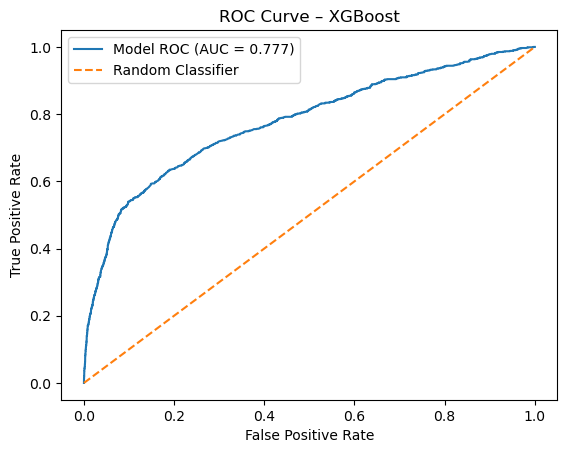

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

plt.plot(fpr, tpr, color='#1f77b4', label=f"Model ROC (AUC = {auc:.3f})")  
plt.plot([0, 1], [0, 1], '--', color='#ff7f0e', label="Random Classifier")  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost")
plt.legend()
plt.show()

In [34]:
#Feature Importance
feature_names = dv_full.feature_names_
importance_scores = model.feature_importances_

# Create clean DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_scores
}).sort_values('importance', ascending=False)

# Top 10 with clean names
print("Top 10 Features:")
print(feature_importance_df.head(10)[['feature', 'importance']])

Top 10 Features:
             feature  importance
50  poutcome=success    0.332893
2   contact=cellular    0.133043
46         month=oct    0.063317
43         month=mar    0.055319
9         default=no    0.052723
42         month=jun    0.044652
47         month=sep    0.035872
38         month=apr    0.023105
40         month=dec    0.019671
41         month=jul    0.016541


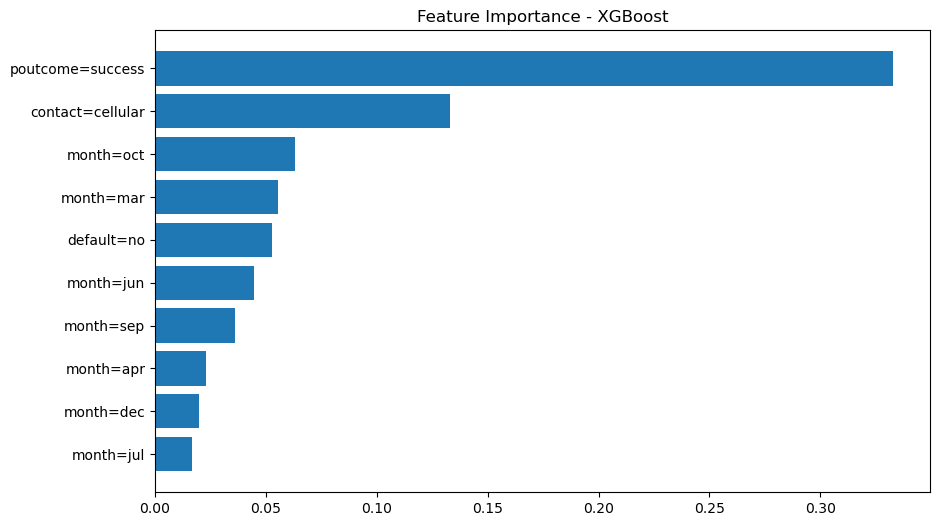

In [36]:
# Simple plot with clean names
top_10 = feature_importance_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_10['feature'], top_10['importance'])
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.show()

**Key Insights:**

1. `poutcome=success` dominates (**~0.35**)

- Previous campaign success is the strongest predictor.
Makes sense as Past behavior predicts future behavior.

2. `contact=cellular` is 2nd (**~0.12**)

- Contact method matters significantly.
Cellular contacts are more effective than telephone.

3. **Seasonal patterns matter**:

- March, June, October show up in top features.
Marketing timing is crucial.

4. `default=no` in **top 10**:

- Credit history matters for financial products.